In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# === LOAD CIFAR ===
DATA_FOLDER = './data/'
BATCH_SIZE = 128
print("Load CIFAR-10...", end="")
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root=DATA_FOLDER, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=DATA_FOLDER, train=False, download=True, transform=transform)

ALL_TRAIN_LEN = len(train_dataset)
ALL_TEST_LEN = len(test_dataset)

all_train_loader = DataLoader(train_dataset, batch_size=ALL_TRAIN_LEN, shuffle=False)
all_test_loader = DataLoader(test_dataset, batch_size=ALL_TEST_LEN, shuffle=False)

all_train_images, all_train_labels = next(iter(all_train_loader))
all_test_images, all_test_labels = next(iter(all_test_loader))

all_train_images_flat = all_train_images.view(ALL_TRAIN_LEN, -1)  # (N, 3072)
all_test_images_flat = all_test_images.view(ALL_TEST_LEN, -1)

Load CIFAR-10...

In [ ]:
# === DIMENSIONS ===
#DST_DIMS = range(10, 500, 20)

DST_DIMS = [10, 35, 500]
dsts_train, dsts_test = dict(), dict()

print("\nCreating low-dim CIFAR datasets...")
for n_pcs in DST_DIMS:
    print(f"{n_pcs} PCs")
    pca = PCA(n_components=n_pcs)
    pca.fit(all_train_images_flat)

    # Train
    rec_train = pca.inverse_transform(pca.transform(all_train_images_flat))
    rec_train_tensor = torch.Tensor(rec_train).view(-1, 3, 32, 32)
    trainset = TensorDataset(rec_train_tensor, all_train_labels)
    dsts_train[n_pcs] = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    # Test
    rec_test = pca.inverse_transform(pca.transform(all_test_images_flat))
    rec_test_tensor = torch.Tensor(rec_test).view(-1, 3, 32, 32)
    testset = TensorDataset(rec_test_tensor, all_test_labels)
    dsts_test[n_pcs] = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print("PCA done.")


Creating low-dim CIFAR datasets...
10 PCs
35 PCs
500 PCs
PCA done.


In [ ]:
# === CLASSIFIER ===
class Classifier(nn.Module):
    def __init__(self, input_dim=3072, num_classes=10):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies, title_prefix="Classifier", save_path=None):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, test_losses, label='Test Loss', marker='x')
    plt.title(f'{title_prefix} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='x')
    plt.title(f'{title_prefix} - Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()

    # === Save to file if path provided ===
    if save_path:
        plt.savefig(save_path)

    plt.show()


ReconClassifier Epoch 1, Loss: 456.87, Train Acc: 58.31%
### DIM=10 ###
Accuracy on Reconstructed Images (Separate Classifier): 31.45%
Saved best model with 31.45% accuracy at dim 10
### DIM=35 ###
Accuracy on Reconstructed Images (Separate Classifier): 46.26%
Saved best model with 46.26% accuracy at dim 35
### DIM=500 ###
Accuracy on Reconstructed Images (Separate Classifier): 51.80%
Saved best model with 51.80% accuracy at dim 500
ReconClassifier Epoch 2, Loss: 452.41, Train Acc: 58.77%
### DIM=10 ###
Accuracy on Reconstructed Images (Separate Classifier): 31.35%
### DIM=35 ###
Accuracy on Reconstructed Images (Separate Classifier): 46.47%
### DIM=500 ###
Accuracy on Reconstructed Images (Separate Classifier): 52.08%
Saved best model with 52.08% accuracy at dim 500
ReconClassifier Epoch 3, Loss: 448.34, Train Acc: 59.06%
### DIM=10 ###
Accuracy on Reconstructed Images (Separate Classifier): 32.08%
### DIM=35 ###
Accuracy on Reconstructed Images (Separate Classifier): 46.50%
### DIM=5

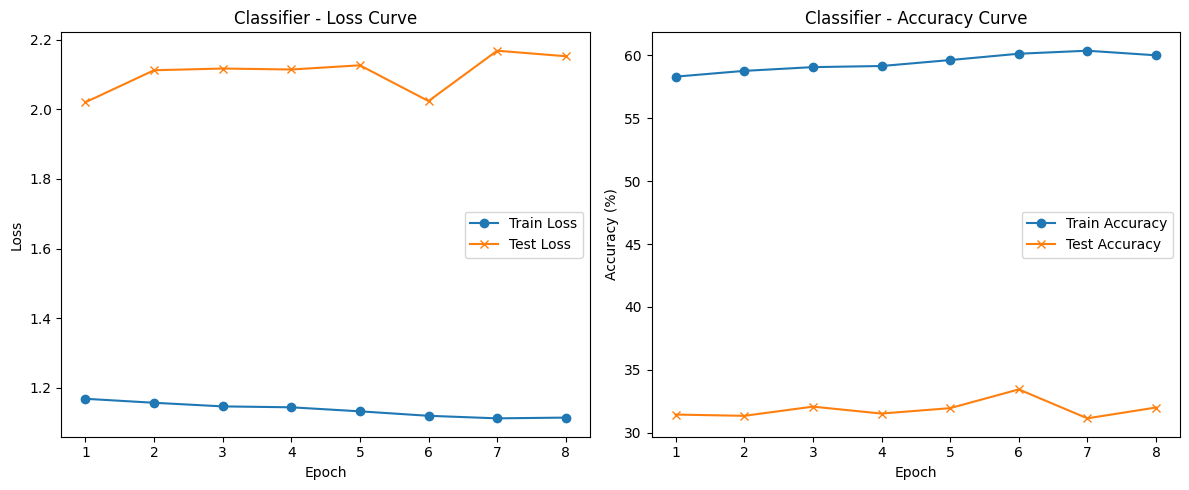

### DIM=35 ###
Accuracy on Reconstructed Images (Separate Classifier): 46.97%


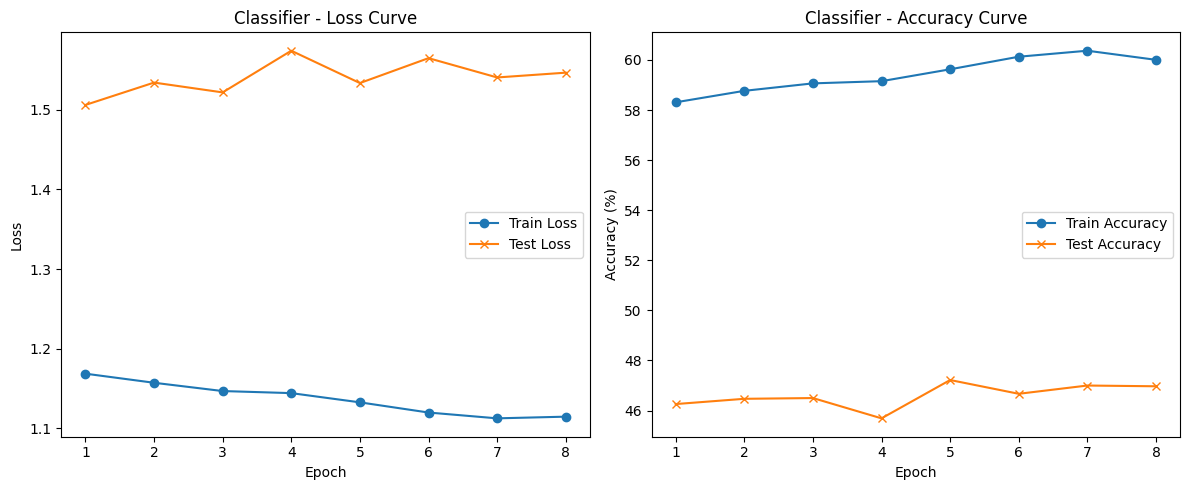

### DIM=500 ###
Accuracy on Reconstructed Images (Separate Classifier): 52.08%


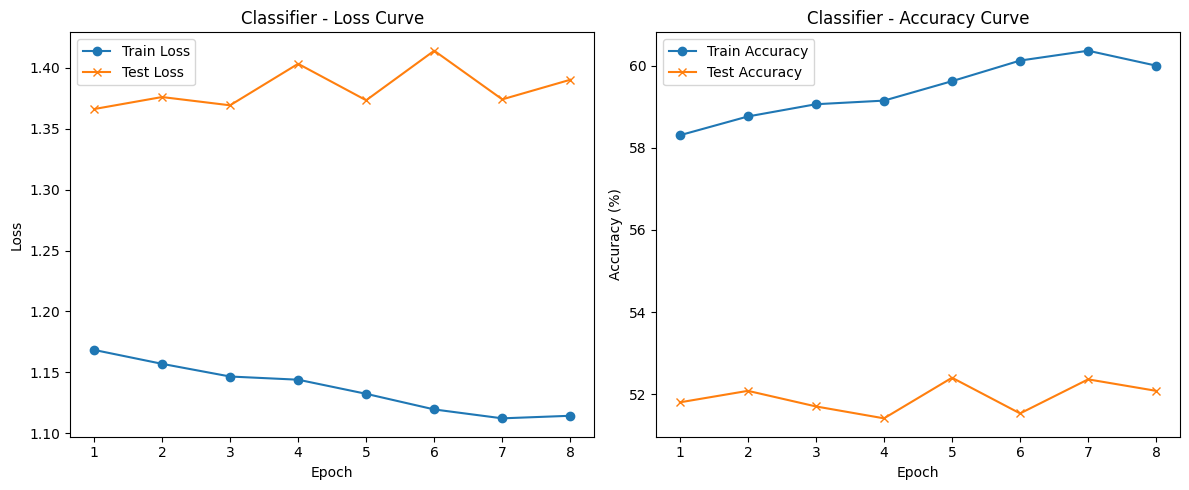

In [ ]:
best_acc = 0
best_model_path = "best_recon_classifier.pt"

clf_epochs = 8
clf_train_losses, clf_train_accuracies = [], []
clf_test_losses = {dim: [] for dim in DST_DIMS}
clf_test_accuracies = {dim: [] for dim in DST_DIMS}

for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in dsts_train[n_pcs]:
        # Flatten the input
        data = data.view(data.size(0), -1).to(device)
        target = target.to(device)

        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()

        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)

    train_acc = 100. * correct / total
    clf_train_losses.append(clf_loss / len(dsts_train[n_pcs]))
    clf_train_accuracies.append(train_acc)

    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {train_acc:.2f}%")

    # === Evaluation on reconstructed images ===
    for dim in DST_DIMS:
        print(f"### DIM={dim} ###")
        recon_clf.eval()
        test_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for data, target in dsts_test[dim]:
                data = data.view(data.size(0), -1).to(device)
                target = target.to(device)
                logits = recon_clf(data)
                loss = F.cross_entropy(logits, target)
                test_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)

        recon_acc = 100. * correct / total
        avg_test_loss = test_loss / len(dsts_test[dim])
        clf_test_losses[dim].append(avg_test_loss)
        clf_test_accuracies[dim].append(recon_acc)

        print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

        # === Save best model ===
        if recon_acc > best_acc:
            best_acc = recon_acc
            torch.save(recon_clf.state_dict(), best_model_path)
            print(f"Saved best model with {best_acc:.2f}% accuracy at dim {dim}")

        # === Plot training curves at last epoch ===
        if epoch == clf_epochs - 1:
            plot_training_curves(
                clf_train_losses,
                clf_test_losses[dim],
                clf_train_accuracies,
                clf_test_accuracies[dim],
                save_path=f"training_curve_dim{dim}.png"
            )


Text(0, 0.5, 'Accuracy %')

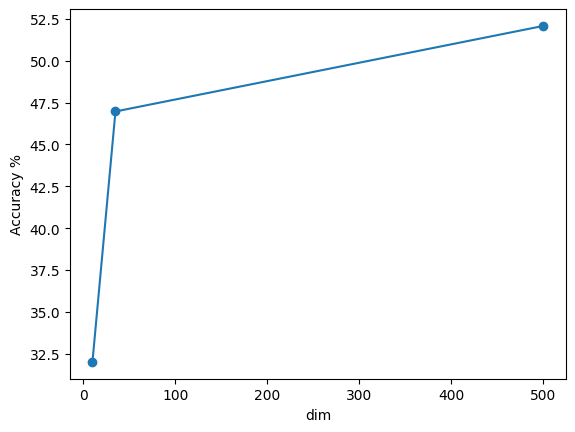

In [ ]:
plt.plot(DST_DIMS, [clf_test_accuracies[dim][-1] for dim in DST_DIMS], "o-")
plt.xlabel("dim")
plt.ylabel("Accuracy %")

In [ ]:
# === DIMENSIONS ===
#DST_DIMS = range(10, 500, 20)

DST_DIMS = [10, 35, 50, 100, 200, 300, 500]
dsts_train, dsts_test = dict(), dict()

print("\nCreating low-dim CIFAR datasets...")
for n_pcs in DST_DIMS:
    print(f"{n_pcs} PCs")
    pca = PCA(n_components=n_pcs)
    pca.fit(all_train_images_flat)

    # Train
    rec_train = pca.inverse_transform(pca.transform(all_train_images_flat))
    rec_train_tensor = torch.Tensor(rec_train).view(-1, 3, 32, 32)
    trainset = TensorDataset(rec_train_tensor, all_train_labels)
    dsts_train[n_pcs] = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    # Test
    rec_test = pca.inverse_transform(pca.transform(all_test_images_flat))
    rec_test_tensor = torch.Tensor(rec_test).view(-1, 3, 32, 32)
    testset = TensorDataset(rec_test_tensor, all_test_labels)
    dsts_test[n_pcs] = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print("PCA done.")


Creating low-dim CIFAR datasets...
10 PCs
35 PCs
50 PCs
100 PCs
200 PCs
300 PCs
500 PCs
PCA done.


In [ ]:
recon_clf = Classifier().to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)

ReconClassifier Epoch 1, Loss: 730.95, Train Acc: 32.24%
### DIM=10 ###
Accuracy on Reconstructed Images (Separate Classifier): 33.13%
Saved best model with 33.13% accuracy at dim 10
### DIM=35 ###
Accuracy on Reconstructed Images (Separate Classifier): 37.53%
Saved best model with 37.53% accuracy at dim 35
### DIM=50 ###
Accuracy on Reconstructed Images (Separate Classifier): 37.77%
Saved best model with 37.77% accuracy at dim 50
### DIM=100 ###
Accuracy on Reconstructed Images (Separate Classifier): 38.81%
Saved best model with 38.81% accuracy at dim 100
### DIM=200 ###
Accuracy on Reconstructed Images (Separate Classifier): 39.10%
Saved best model with 39.10% accuracy at dim 200
### DIM=300 ###
Accuracy on Reconstructed Images (Separate Classifier): 39.05%
### DIM=500 ###
Accuracy on Reconstructed Images (Separate Classifier): 39.11%
Saved best model with 39.11% accuracy at dim 500
ReconClassifier Epoch 2, Loss: 656.83, Train Acc: 39.91%
### DIM=10 ###
Accuracy on Reconstructed Imag

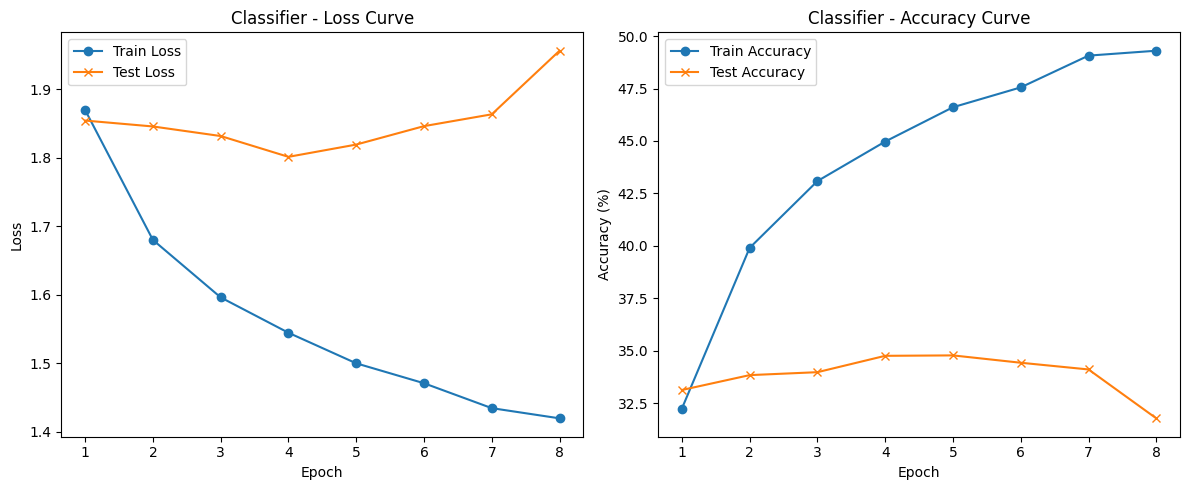

### DIM=35 ###
Accuracy on Reconstructed Images (Separate Classifier): 44.03%


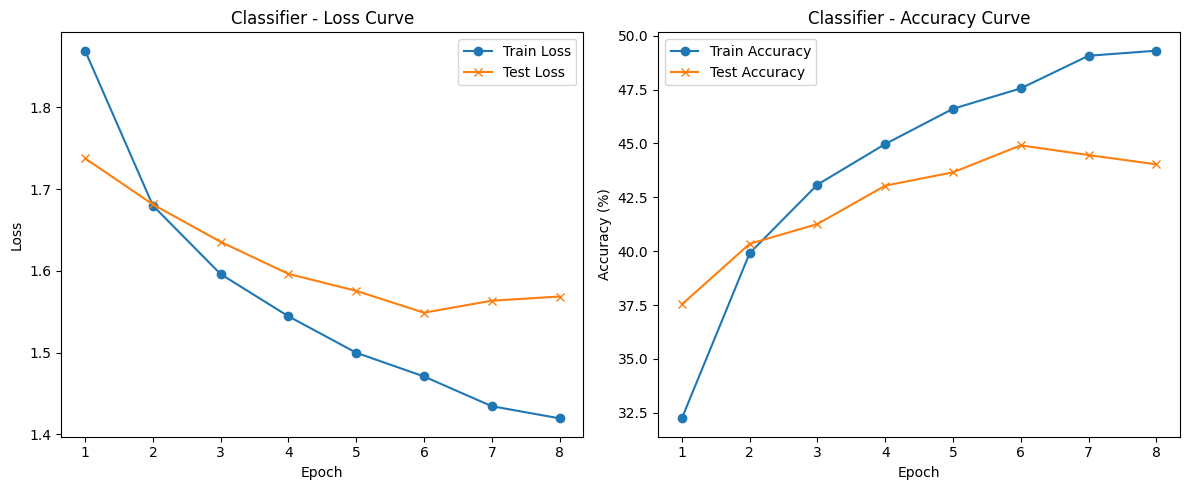

### DIM=50 ###
Accuracy on Reconstructed Images (Separate Classifier): 44.15%


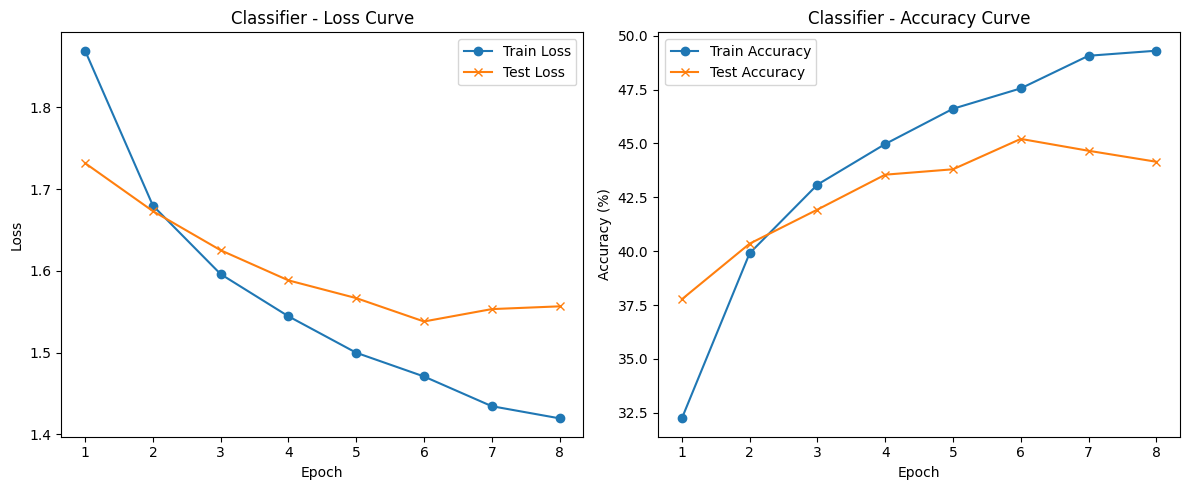

### DIM=100 ###
Accuracy on Reconstructed Images (Separate Classifier): 46.36%


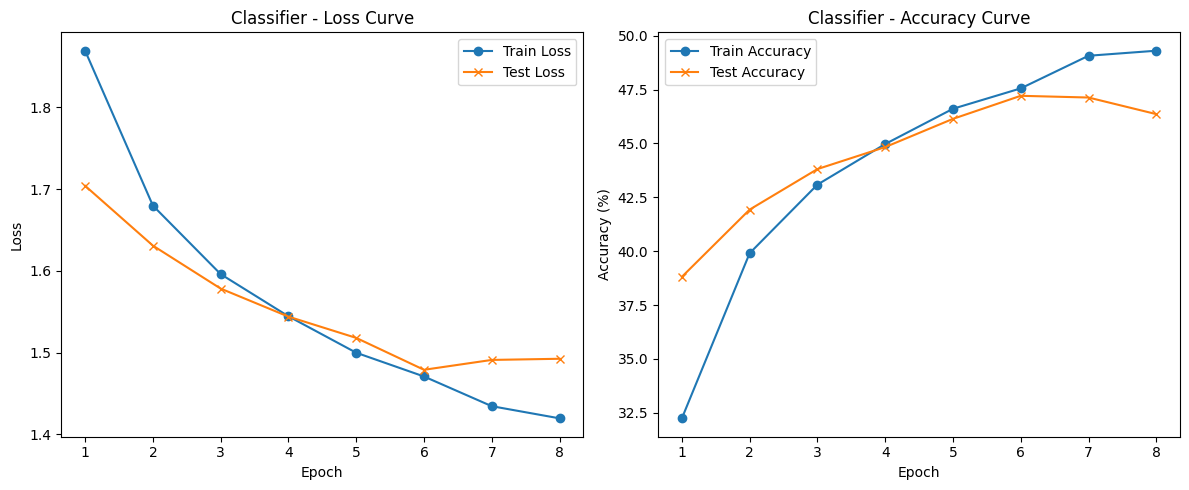

### DIM=200 ###
Accuracy on Reconstructed Images (Separate Classifier): 46.92%


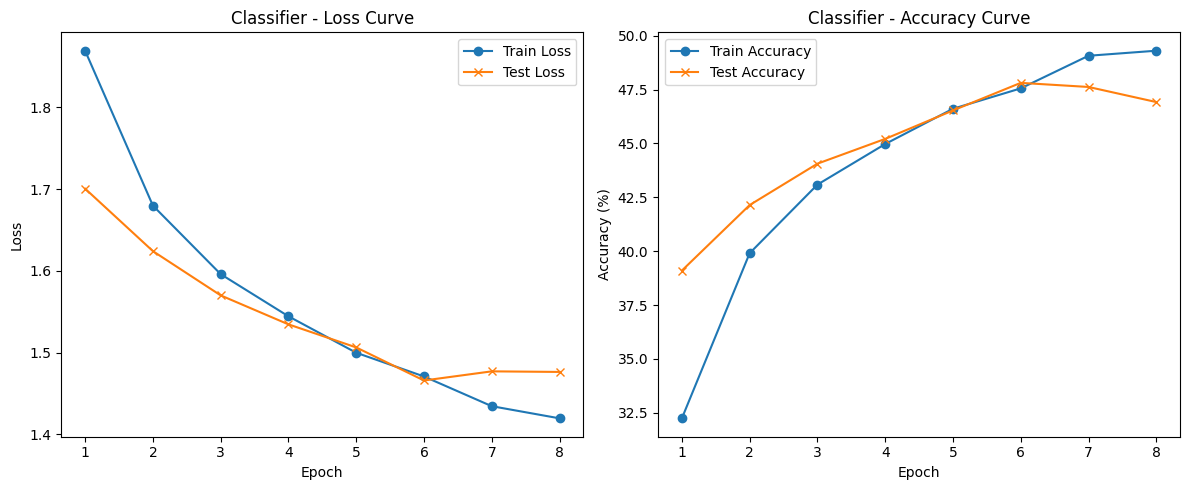

### DIM=300 ###
Accuracy on Reconstructed Images (Separate Classifier): 47.03%


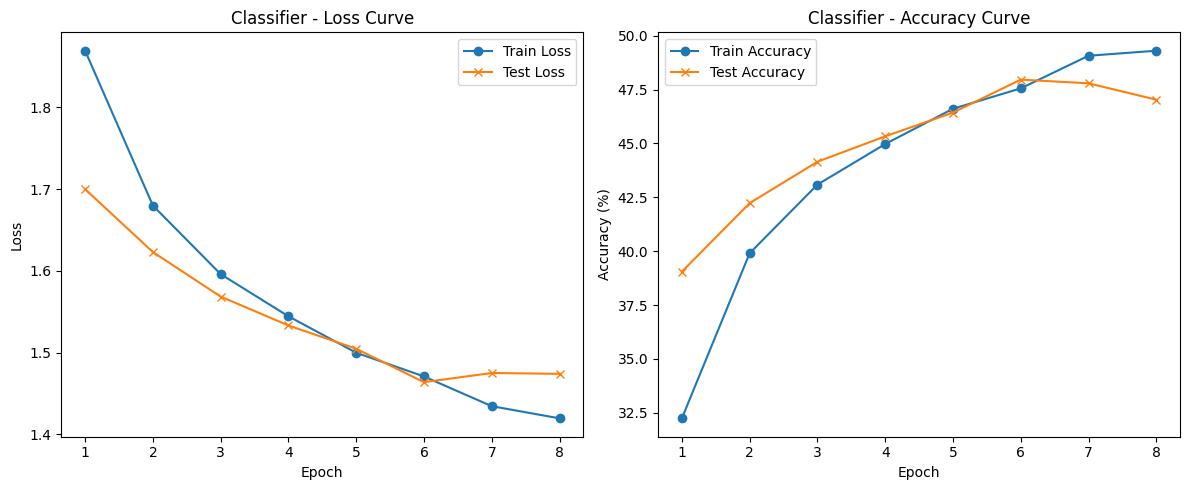

### DIM=500 ###
Accuracy on Reconstructed Images (Separate Classifier): 47.19%


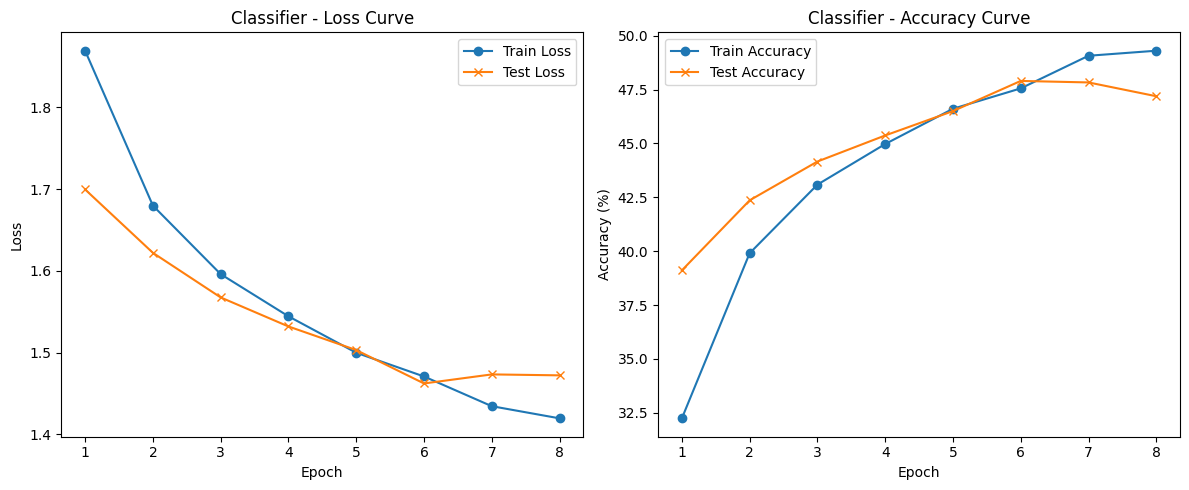

In [ ]:
best_acc = 0
best_model_path = "best_recon_classifier1.pt"

clf_epochs = 8
clf_train_losses, clf_train_accuracies = [], []
clf_test_losses = {dim: [] for dim in DST_DIMS}
clf_test_accuracies = {dim: [] for dim in DST_DIMS}

for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in dsts_train[n_pcs]:
        # Flatten the input
        data = data.view(data.size(0), -1).to(device)
        target = target.to(device)

        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()

        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)

    train_acc = 100. * correct / total
    clf_train_losses.append(clf_loss / len(dsts_train[n_pcs]))
    clf_train_accuracies.append(train_acc)

    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {train_acc:.2f}%")

    # === Evaluation on reconstructed images ===
    for dim in DST_DIMS:
        print(f"### DIM={dim} ###")
        recon_clf.eval()
        test_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for data, target in dsts_test[dim]:
                data = data.view(data.size(0), -1).to(device)
                target = target.to(device)
                logits = recon_clf(data)
                loss = F.cross_entropy(logits, target)
                test_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)

        recon_acc = 100. * correct / total
        avg_test_loss = test_loss / len(dsts_test[dim])
        clf_test_losses[dim].append(avg_test_loss)
        clf_test_accuracies[dim].append(recon_acc)

        print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

        # === Save best model ===
        if recon_acc > best_acc:
            best_acc = recon_acc
            torch.save(recon_clf.state_dict(), best_model_path)
            print(f"Saved best model with {best_acc:.2f}% accuracy at dim {dim}")

        # === Plot training curves at last epoch ===
        if epoch == clf_epochs - 1:
            plot_training_curves(
                clf_train_losses,
                clf_test_losses[dim],
                clf_train_accuracies,
                clf_test_accuracies[dim],
                save_path=f"training_curve_dim{dim}.png"
            )

Text(0, 0.5, 'Accuracy %')

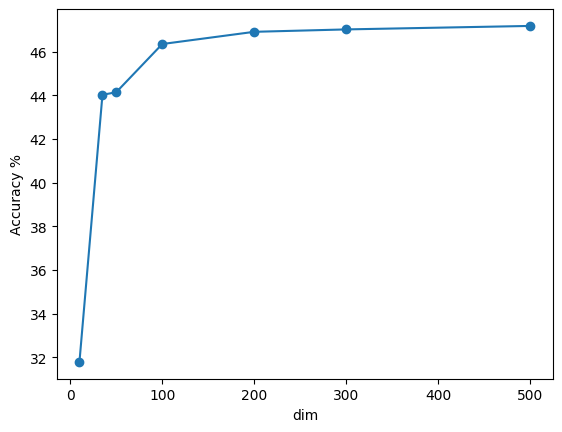

In [ ]:
plt.plot(DST_DIMS, [clf_test_accuracies[dim][-1] for dim in DST_DIMS], "o-")
plt.xlabel("dim")
plt.ylabel("Accuracy %")